<a href="https://colab.research.google.com/github/AfrozSaqlain/Physics-Informed-Neural-Network/blob/main/PM_Amplification_Factor.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!git clone https://git.ligo.org/anuj.mishra/gwmat.git

Cloning into 'gwmat'...
remote: Enumerating objects: 2017, done.
remote: Counting objects: 100% (2017/2017), done.
remote: Compressing objects: 100% (1043/1043), done.
remote: Total 2017 (delta 997), reused 1932 (delta 954), pack-reused 0 (from 0)
Receiving objects: 100% (2017/2017), 76.41 MiB | 6.70 MiB/s, done.
Resolving deltas: 100% (997/997), done.


In [2]:
!pip install gwmat/.

Processing ./gwmat
  Preparing metadata (setup.py) ... done
  Created wheel for gwmat: filename=gwmat-1.0.0-cp311-cp311-linux_x86_64.whl size=1835288 sha256=393e24764051ef58db8c6531b50a4c22053a4e0a6802bdad776c78bbbce707cb
  Stored in directory: /tmp/pip-ephem-wheel-cache-cgt5ym2f/wheels/cd/f2/60/392210aec2bd427d21e1e98b42754563f518b98aaf4a0c40c5
Successfully built gwmat


In [3]:
!pip install mpmath gmpy2 bilby lalsuite pycbc

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 51.0/51.0 kB 5.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.6/47.6 kB 4.0 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 6.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.1/47.1 kB 4.6 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 53.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 4.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.4/40.4 MB 16.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.0/9.0 MB 6.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━

In [4]:
import torch
import torch.nn as nn
import gwmat
import matplotlib.pyplot as plt
import numpy as np
from torch.utils.data import Dataset, DataLoader
from torch.optim.lr_scheduler import ReduceLROnPlateau
import bilby
import os
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

/usr/local/lib/python3.11/dist-packages/lalsimulation/lalsimulation.py:8: UserWarning: Wswiglal-redir-stdio:

SWIGLAL standard output/error redirection is enabled in IPython.
This may lead to performance penalties. To disable locally, use:

with lal.no_swig_redirect_standard_output_error():
    ...

To disable globally, use:

lal.swig_redirect_standard_output_error(False)

Note however that this will likely lead to error messages from
LAL functions being either misdirected or lost when called from
Jupyter notebooks.

To suppress this warning, use:

import warnings
warnings.filterwarnings("ignore", "Wswiglal-redir-stdio")
import lal

  import lal


In [ ]:
# Hyperparameters
BATCH_SIZE = 1000
LEARNING_RATE = 0.001
EPOCHS = 200
PATIENCE = 20
FACTOR = 0.1
ERROR_MARGIN = 15
EARLY_STOPPING_PATIENCE = 100
DROPOUT_RATE = 0.5

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

# Define priors
prior = bilby.core.prior.PriorDict()
prior['Mlz'] = bilby.prior.LogUniform(minimum=100, maximum=1e5, name='Mlz', latex_label='Mlz')
prior['y'] = bilby.prior.PowerLaw(alpha=0.1, minimum=0.001, maximum=3, name='Mlz', latex_label='Mlz')

fs = np.logspace(1, 3, num=2000, endpoint=True, base=10.0)
samples = prior.sample(200)

In [ ]:
X = torch.tensor([[mlz, y, f] for mlz, y in zip(samples['Mlz'], samples['y']) for f in fs], dtype=torch.float32).to(device)
y = torch.tensor([np.abs(gwmat.cythonized_point_lens.Ff_effective(ml=row[0], y=row[1], f=row[2])) for row in X.cpu().numpy()], dtype=torch.float32).to(device)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42, shuffle=True)

In [ ]:
X_train, y_train

(tensor([[2.6363e+02, 2.2074e+00, 7.8424e+01],
         [3.3700e+02, 7.9456e-01, 3.6879e+02],
         [1.9428e+04, 1.6278e-01, 2.5954e+01],
         ...,
         [3.1069e+02, 2.3243e+00, 8.5697e+02],
         [1.2631e+02, 2.0889e+00, 7.3694e+01],
         [3.3655e+02, 2.4984e+00, 9.0987e+02]]),
 tensor([1.1199, 1.2073, 3.5069,  ..., 1.0942, 0.9359, 0.8836]))

In [ ]:
class CustomDataset(Dataset):
    def __init__(self, tensor1, tensor2):
        self.tensor1 = tensor1
        self.tensor2 = tensor2

    def __len__(self):
        return len(self.tensor1)

    def __getitem__(self, idx):
        x = self.tensor1[idx]
        y = self.tensor2[idx]
        return x, y

# Create the dataset and DataLoader
train_dataset = CustomDataset(X_train, y_train)
test_dataset = CustomDataset(X_test, y_test)
train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=0)
test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=0)

In [ ]:
import torch.nn as nn

class PINN(nn.Module):
    def __init__(self, input_shape: int, hidden_dim: int, output_features: int):
        super().__init__()
        self.layers = nn.Sequential(
            nn.Flatten(),
            nn.Linear(input_shape, hidden_dim),
            nn.LeakyReLU(negative_slope=0.01),
            nn.Dropout(DROPOUT_RATE),
            nn.Linear(hidden_dim, hidden_dim // 2),
            nn.LeakyReLU(negative_slope=0.01),
            nn.Dropout(DROPOUT_RATE),
            nn.Linear(hidden_dim // 2, output_features)
        )

    def forward(self, x):
        return self.layers(x)

In [ ]:
model_1 = PINN(3, 48, 1).to(device)
loss_func = nn.MSELoss()
optimizer = torch.optim.Adam(model_1.parameters(), lr=LEARNING_RATE)
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=FACTOR, patience=PATIENCE)

In [ ]:
def train_test(model: nn.Module,
               optimizer: torch.optim.Optimizer,
               train_dataloader: DataLoader,
               test_dataloader: DataLoader,
               epochs: int):
    train_loss = np.array([])
    test_loss = np.array([])
    best_loss = float('inf')
    early_stopping_counter = 0

    for epoch in range(epochs):
        model.train()
        train_epoch_loss = 0
        for X_batch, y_batch in train_dataloader:
            optimizer.zero_grad()
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            y_pred = model(X_batch).squeeze(dim=1)
            loss = loss_func(y_pred, y_batch)
            loss.backward()
            optimizer.step()
            train_epoch_loss += loss.item()

        train_loss = np.append(train_loss, train_epoch_loss / len(train_dataloader))

        if epoch % 10 == 0:
            current_lr = scheduler.get_last_lr()
            print(f'Epoch {epoch}:-> Train Loss: {train_epoch_loss / len(train_dataloader)}, Learning Rate: {current_lr[0]}')

        model.eval()
        test_epoch_loss = 0

        with torch.no_grad():
            for X_batch, y_batch in test_dataloader:
                X_batch, y_batch = X_batch.to(device), y_batch.to(device)
                y_pred = model(X_batch).squeeze(dim=1)
                loss = loss_func(y_pred, y_batch)
                test_epoch_loss += loss.item()

            test_loss = np.append(test_loss, test_epoch_loss / len(test_dataloader))

            if epoch % 10 == 0:
                print(f'Epoch {epoch}:-> Test Loss: {test_epoch_loss / len(test_dataloader)}')

        # Step the scheduler with the validation loss
        scheduler.step(test_epoch_loss / len(test_dataloader))

        # Early stopping
        if test_epoch_loss < best_loss:
            best_loss = test_epoch_loss
            early_stopping_counter = 0
        else:
            early_stopping_counter += 1

        if early_stopping_counter >= EARLY_STOPPING_PATIENCE:
            print(f"Early stopping at epoch {epoch}")
            break

    return train_loss, test_loss

In [ ]:
train_loss_, test_loss_ = train_test(model=model_1,
                                     optimizer=optimizer,
                                     train_dataloader=train_dataloader,
                                     test_dataloader=test_dataloader,
                                     epochs=EPOCHS)

Epoch 0:-> Train Loss: 269873.84044921875, Learning Rate: 0.001
Epoch 0:-> Test Loss: 905.2092889404297
Epoch 10:-> Train Loss: 705.9497617594401, Learning Rate: 0.001
Epoch 10:-> Test Loss: 6.736096997261047
Epoch 20:-> Train Loss: 71.43757472991943, Learning Rate: 0.001
Epoch 20:-> Test Loss: 0.7660011434555054
Epoch 30:-> Train Loss: 1.5906263842185338, Learning Rate: 0.001
Epoch 30:-> Test Loss: 0.27672381430864335
Epoch 40:-> Train Loss: 0.39831245616078376, Learning Rate: 0.001
Epoch 40:-> Test Loss: 0.26992995709180834
Epoch 50:-> Train Loss: 0.34844617555538815, Learning Rate: 0.001
Epoch 50:-> Test Loss: 0.2682118830084801
Epoch 60:-> Train Loss: 0.2993371665974458, Learning Rate: 0.001
Epoch 60:-> Test Loss: 0.2681638170778751
Epoch 70:-> Train Loss: 0.2855234529574712, Learning Rate: 0.0001
Epoch 70:-> Test Loss: 0.26827435567975044
Epoch 80:-> Train Loss: 0.28799463555216787, Learning Rate: 0.0001
Epoch 80:-> Test Loss: 0.26993281319737433
Epoch 90:-> Train Loss: 0.28430550

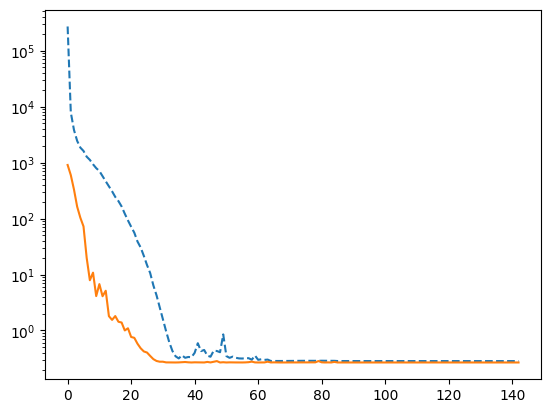

In [ ]:
plt.plot(np.arange(len(train_loss_)), train_loss_, linestyle='--')
plt.plot(np.arange(len(test_loss_)), test_loss_)
plt.yscale('log')
plt.savefig('TT_Loss.png')

In [ ]:
count = 0
total_count = 0

with torch.no_grad():
    for X_batch, y_batch in test_dataloader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        y_pred = model_1(X_batch).squeeze(dim=1)

        for i in range(len(y_pred)):
            total_count += 1
            if (np.abs(y_pred[i].cpu() - y_batch[i].cpu()) / y_batch[i].cpu()) * 100 < ERROR_MARGIN:
                count += 1

print(f"{count} out of {total_count}, i.e. {count / total_count * 100 :.2f}% of predicted Amplification factor values lie within {ERROR_MARGIN}% error margin.")

40309 out of 100000, i.e. 40.31% of predicted Amplification factor values lie within 15% error margin.


In [ ]:
train_count = 0
total_train_count = 0

with torch.no_grad():
    for X_batch, y_batch in train_dataloader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        y_pred = model_1(X_batch).squeeze(dim=1)

        for i in range(len(y_pred)):
            total_train_count += 1
            if (np.abs(y_pred[i].cpu() - y_batch[i].cpu()) / y_batch[i].cpu()) * 100 < ERROR_MARGIN:
                train_count += 1

print(f"{train_count} out of {total_train_count}, i.e. {train_count / total_train_count * 100 :.2f}% of predicted Amplification factor values lie within {ERROR_MARGIN}% error margin.")

121663 out of 300000, i.e. 40.55% of predicted Amplification factor values lie within 15% error margin.


# GWMAT Lookup Table

In [ ]:
import gwmat

/usr/local/lib/python3.10/dist-packages/lalsimulation/lalsimulation.py:8: UserWarning: Wswiglal-redir-stdio:

SWIGLAL standard output/error redirection is enabled in IPython.
This may lead to performance penalties. To disable locally, use:

with lal.no_swig_redirect_standard_output_error():
    ...

To disable globally, use:

lal.swig_redirect_standard_output_error(False)

Note however that this will likely lead to error messages from
LAL functions being either misdirected or lost when called from
Jupyter notebooks.

To suppress this warning, use:

import warnings
warnings.filterwarnings("ignore", "Wswiglal-redir-stdio")
import lal

  import lal


In [ ]:
gw150914_params = {
    "mass_1" :  36.899196999999994,
    "mass_2" :  32.841122,
    "a_1" :  0.4589379196155383,
    "a_2" :  0.6217996075936105,
    "tilt_1" :  1.3119020553581624,
    "tilt_2" :  1.9677689908003024,
    "phi_jl" :  5.066189795720256,
    "phi_12" :  2.35369776837124,
    "ra" :  1.6894226000000003,
    "dec" :  -1.2408674,
    "psi" :  1.205441068972152,
    "phase" :  3.719825515003542,
    "luminosity_distance" :  402.60244,
    "theta_jn" :  2.74767078690558,
    "geocent_time":  1126259462.426434,
}

In [ ]:
init_params = dict(wf_domain="TD", f_start=15, f_ref=20., sample_rate=4096,
                   delta_t=None, wf_approximant="IMRPhenomXO4a")
lens_params = dict(m_lens=1e3, y_lens=1) # THESE ARE LENS PARAMETERS
cbc_params =  gw150914_params
misc_params = dict(rwrap = -0., cyclic_time_shift_method = "pycbc",
                   taper_hp_hc=True,  hp_hc_extra_padding_at_start=0,
                   make_hp_hc_duration_power_of_2=True)
params = {**init_params, **cbc_params, **lens_params, **misc_params}

res = gwmat.injection.generate_gw_polarizations_hp_hc(**params)

In [ ]:
wf_hp = res["hp_FD_Lensed"]
wf_hc = res["hp_FD_Unlensed"]

In [ ]:
import matplotlib.pyplot as plt

(10, 1024)

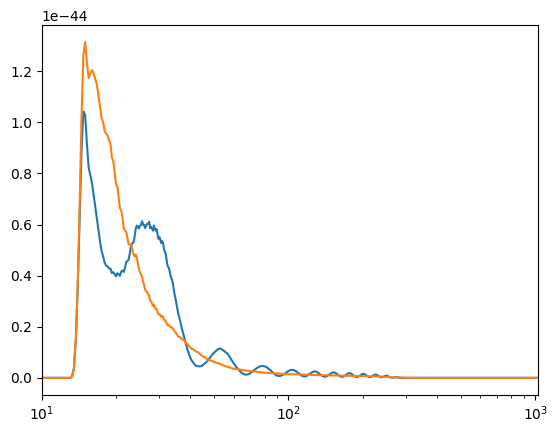

In [ ]:
plt.plot(wf_hp.sample_frequencies, wf_hp.squared_norm())
plt.plot(wf_hc.sample_frequencies, wf_hc.squared_norm())
plt.xscale('log')
plt.xlim(10, 1024)

# F(f) calculation for one point mass lens

In [28]:
mlz = 1e3
yl = 1
fs = np.logspace(1, 3, num=200, endpoint = True, base = 10.0)

In [57]:
EPOCHS = 200
LEARNING_RATE = 0.001

In [65]:
class PM_FF(nn.Module):
  def __init__(self):
    super().__init__()

    self.layers = nn.Sequential(
      nn.Linear(3, 100),
      nn.ReLU(),
      nn.Linear(100, 100),
      nn.ReLU(),
      nn.Linear(100, 1)
    )

  def forward(self, x):
    return self.layers(x)

model_0 = PM_FF()

loss_fn = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model_0.parameters(), lr = LEARNING_RATE)
# scheduler = ReduceLROnPlateau(optimizer, mode = 'min', factor = 0.1, patience = 10)

In [66]:
for epoch in range(EPOCHS):
  model_0.train()
  check = 100
  for f in fs:
    X = torch.tensor([[mlz, yl, f]], dtype = torch.float32)
    y = torch.tensor([np.abs(gwmat.cythonized_point_lens.Ff_effective(ml = mlz, y = yl, f = f))], dtype = torch.float32)
    y_pred = model_0(X)
    loss = loss_fn(y_pred, y)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    # scheduler.step(loss)

  if loss < check:
      check = loss
  elif loss >= check and epoch != 0:
    print(f'Breaking at epoch no. {epoch}')
    break
  if epoch % 10 == 0:
    print(f'Epoch {epoch}:-> Loss: {loss.item()}')

Epoch 0:-> Loss: 9.118501663208008
Epoch 10:-> Loss: 2.5443711280822754
Epoch 20:-> Loss: 2.149308681488037
Epoch 30:-> Loss: 0.31551438570022583
Epoch 40:-> Loss: 0.503737211227417
Epoch 50:-> Loss: 0.07321394979953766
Epoch 60:-> Loss: 0.013806154020130634
Epoch 70:-> Loss: 0.020946867763996124
Epoch 80:-> Loss: 0.06722183525562286
Epoch 90:-> Loss: 0.0014425679109990597
Epoch 100:-> Loss: 0.0011864530388265848
Epoch 110:-> Loss: 0.0005072285421192646
Epoch 120:-> Loss: 0.0005064019351266325
Epoch 130:-> Loss: 0.0005063965800218284
Epoch 140:-> Loss: 0.0005063858116045594
Epoch 150:-> Loss: 0.0005063858116045594
Epoch 160:-> Loss: 0.0005063858116045594
Epoch 170:-> Loss: 0.0005063858116045594
Epoch 180:-> Loss: 0.0005063858116045594
Epoch 190:-> Loss: 0.0005063858116045594


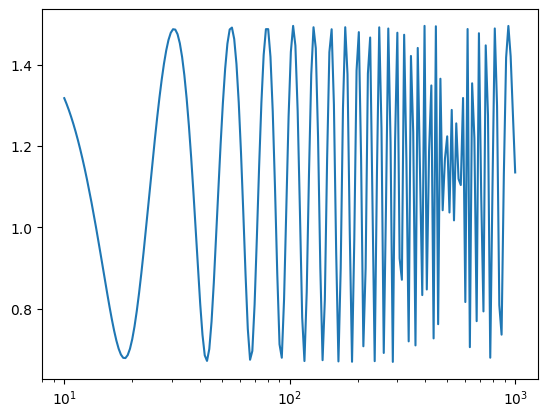

In [67]:
test = [np.abs(gwmat.cythonized_point_lens.Ff_effective(ml = mlz, y = yl, f = f)) for f in fs]
plt.plot(fs, test)
plt.xscale('log')

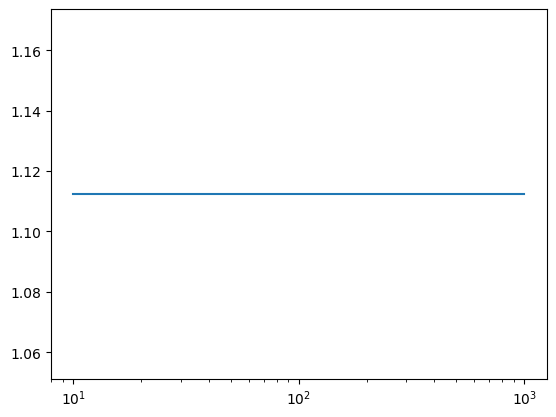

In [68]:
model_pred = [model_0(y).detach().numpy() for y in torch.tensor([[mlz, yl, f] for f in fs], dtype = torch.float32)]
plt.plot(fs, model_pred)
plt.xscale('log')

In [69]:
print([model_0(y).detach().numpy() for y in torch.tensor([[mlz, yl, f] for f in fs], dtype = torch.float32)])

[array([1.1124071], dtype=float32), array([1.1124071], dtype=float32), array([1.1124071], dtype=float32), array([1.1124071], dtype=float32), array([1.1124071], dtype=float32), array([1.1124071], dtype=float32), array([1.1124071], dtype=float32), array([1.1124071], dtype=float32), array([1.1124071], dtype=float32), array([1.1124071], dtype=float32), array([1.1124071], dtype=float32), array([1.1124071], dtype=float32), array([1.1124071], dtype=float32), array([1.1124071], dtype=float32), array([1.1124071], dtype=float32), array([1.1124071], dtype=float32), array([1.1124071], dtype=float32), array([1.1124071], dtype=float32), array([1.1124071], dtype=float32), array([1.1124071], dtype=float32), array([1.1124071], dtype=float32), array([1.1124071], dtype=float32), array([1.1124071], dtype=float32), array([1.1124071], dtype=float32), array([1.1124071], dtype=float32), array([1.1124071], dtype=float32), array([1.1124071], dtype=float32), array([1.1124071], dtype=float32), array([1.1124071], 

In [85]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np

# Define constants
mlz = 1e3
yl = 1
fs = np.logspace(1, 3, num=200, endpoint=True, base=10.0)

EPOCHS = 1000
LEARNING_RATE = 0.001
BATCH_SIZE = 32  # Using mini-batches

# Prepare training data
X_train = np.array([[mlz, yl, f] for f in fs], dtype=np.float32)
y_train = np.array([np.abs(gwmat.cythonized_point_lens.Ff_effective(ml=mlz, y=yl, f=f)) for f in fs], dtype=np.float32)

# Convert to PyTorch tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32).view(-1, 1)

# Define model
class PM_FF(nn.Module):
    def __init__(self):
        super().__init__()
        self.layers = nn.Sequential(
            nn.Linear(3, 50),
            nn.ReLU(),
            nn.Linear(50, 100),
            nn.ReLU(),
            nn.Linear(100, 100),
            nn.ReLU(),
            nn.Linear(100, 100),
            nn.ReLU(),
            nn.Linear(100, 100),
            nn.ReLU(),
            nn.Linear(100, 50),
            nn.ReLU(),
            nn.Linear(50, 1)
        )

    def forward(self, x):
        return self.layers(x)

# Initialize model, loss, optimizer
model = PM_FF()
loss_fn = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)
scheduler = ReduceLROnPlateau(optimizer, mode = 'min', factor = 0.1, patience = 10)

# Training loop
for epoch in range(EPOCHS):
    model.train()

    # Shuffle data
    indices = np.random.permutation(len(X_train_tensor))
    X_train_tensor = X_train_tensor[indices]
    y_train_tensor = y_train_tensor[indices]

    epoch_loss = 0.0  # Track loss per epoch

    # Mini-batch training
    for i in range(0, len(X_train_tensor), BATCH_SIZE):
        X_batch = X_train_tensor[i:i+BATCH_SIZE]
        y_batch = y_train_tensor[i:i+BATCH_SIZE]

        # Forward pass
        y_pred = model(X_batch)
        loss = loss_fn(y_pred, y_batch)

        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()  # Accumulate loss for the epoch

    # Compute average loss for the epoch
    avg_loss = epoch_loss / (len(X_train_tensor) / BATCH_SIZE)
    scheduler.step(avg_loss)  # Use average loss for scheduler

    # Print loss every 10 epochs
    if epoch % 10 == 0:
        print(f"Epoch {epoch}: Loss = {avg_loss:.6f}, LR = {optimizer.param_groups[0]['lr']:.1e}")

print("Training complete.")

Epoch 0: Loss = 0.598124, LR = 1.0e-03
Epoch 10: Loss = 0.093608, LR = 1.0e-03
Epoch 20: Loss = 0.081869, LR = 1.0e-03
Epoch 30: Loss = 0.093532, LR = 1.0e-03
Epoch 40: Loss = 0.078049, LR = 1.0e-04
Epoch 50: Loss = 0.084943, LR = 1.0e-04
Epoch 60: Loss = 0.083723, LR = 1.0e-05
Epoch 70: Loss = 0.082336, LR = 1.0e-05
Epoch 80: Loss = 0.088417, LR = 1.0e-06
Epoch 90: Loss = 0.084562, LR = 1.0e-07
Epoch 100: Loss = 0.084063, LR = 1.0e-08
Epoch 110: Loss = 0.082387, LR = 1.0e-08
Epoch 120: Loss = 0.086369, LR = 1.0e-08
Epoch 130: Loss = 0.086925, LR = 1.0e-08
Epoch 140: Loss = 0.081632, LR = 1.0e-08
Epoch 150: Loss = 0.084199, LR = 1.0e-08
Epoch 160: Loss = 0.085049, LR = 1.0e-08
Epoch 170: Loss = 0.081146, LR = 1.0e-08
Epoch 180: Loss = 0.083863, LR = 1.0e-08
Epoch 190: Loss = 0.083826, LR = 1.0e-08
Epoch 200: Loss = 0.084757, LR = 1.0e-08
Epoch 210: Loss = 0.083747, LR = 1.0e-08
Epoch 220: Loss = 0.083903, LR = 1.0e-08
Epoch 230: Loss = 0.083375, LR = 1.0e-08
Epoch 240: Loss = 0.080631,

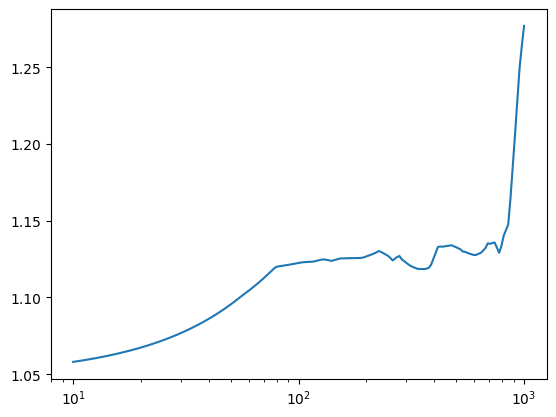

In [86]:
model_pred = [model(y).detach().numpy() for y in torch.tensor([[mlz, yl, f] for f in fs], dtype = torch.float32)]
plt.plot(fs, model_pred)
plt.xscale('log')

In [87]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
from sklearn.preprocessing import StandardScaler
from torch.utils.data import DataLoader, TensorDataset

# Define constants
mlz = 1e3
yl = 1
fs = np.logspace(1, 3, num=200, endpoint=True, base=10.0)

EPOCHS = 300
LEARNING_RATE = 0.01
BATCH_SIZE = 16  # Smaller batch size for better gradient updates

# Prepare dataset
X_train = np.array([[mlz, yl, f] for f in fs], dtype=np.float32)
y_train = np.array([np.abs(gwmat.cythonized_point_lens.Ff_effective(ml=mlz, y=yl, f=f)) for f in fs], dtype=np.float32)

# Normalize inputs
scaler_X = StandardScaler()
X_train = scaler_X.fit_transform(X_train)

# Normalize outputs
scaler_y = StandardScaler()
y_train = scaler_y.fit_transform(y_train.reshape(-1, 1)).flatten()

# Convert to PyTorch tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32).view(-1, 1)

# Create DataLoader
dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True)

# Define model
class SimpleNN(nn.Module):
    def __init__(self):
        super(SimpleNN, self).__init__()
        self.layers = nn.Sequential(
            nn.Linear(3, 64),
            nn.ReLU(),
            nn.Linear(64, 64),
            nn.ReLU(),
            nn.Linear(64, 1)
        )

    def forward(self, x):
        return self.layers(x)

# Initialize model, loss, optimizer
model = SimpleNN()
loss_fn = nn.MSELoss()
optimizer = optim.SGD(model.parameters(), lr=LEARNING_RATE, momentum=0.9)
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=EPOCHS)

# Training loop
for epoch in range(EPOCHS):
    model.train()
    epoch_loss = 0.0

    for X_batch, y_batch in train_loader:
        optimizer.zero_grad()
        y_pred = model(X_batch)
        loss = loss_fn(y_pred, y_batch)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()

    scheduler.step()  # Adjust learning rate

    avg_loss = epoch_loss / len(train_loader)

    if epoch % 10 == 0:
        print(f"Epoch {epoch}: Loss = {avg_loss:.6f}, LR = {optimizer.param_groups[0]['lr']:.5f}")

print("Training complete.")

# Save model
torch.save(model.state_dict(), "function_approximator.pth")

# To make predictions, remember to apply inverse transform:
# y_pred = scaler_y.inverse_transform(model(X_test).detach().numpy())


Epoch 0: Loss = 1.041480, LR = 0.01000
Epoch 10: Loss = 0.999313, LR = 0.00997
Epoch 20: Loss = 1.003265, LR = 0.00988
Epoch 30: Loss = 0.997203, LR = 0.00974
Epoch 40: Loss = 0.989660, LR = 0.00955
Epoch 50: Loss = 1.010477, LR = 0.00930
Epoch 60: Loss = 0.992894, LR = 0.00901
Epoch 70: Loss = 1.000039, LR = 0.00868
Epoch 80: Loss = 0.993264, LR = 0.00831
Epoch 90: Loss = 1.010568, LR = 0.00790
Epoch 100: Loss = 0.988396, LR = 0.00745
Epoch 110: Loss = 0.982621, LR = 0.00699
Epoch 120: Loss = 0.978600, LR = 0.00650
Epoch 130: Loss = 0.973670, LR = 0.00599
Epoch 140: Loss = 0.987056, LR = 0.00547
Epoch 150: Loss = 0.973344, LR = 0.00495
Epoch 160: Loss = 0.987291, LR = 0.00443
Epoch 170: Loss = 0.963570, LR = 0.00391
Epoch 180: Loss = 0.969802, LR = 0.00341
Epoch 190: Loss = 0.965258, LR = 0.00292
Epoch 200: Loss = 0.980581, LR = 0.00245
Epoch 210: Loss = 0.999850, LR = 0.00202
Epoch 220: Loss = 0.989841, LR = 0.00162
Epoch 230: Loss = 0.965906, LR = 0.00125
Epoch 240: Loss = 0.988185,

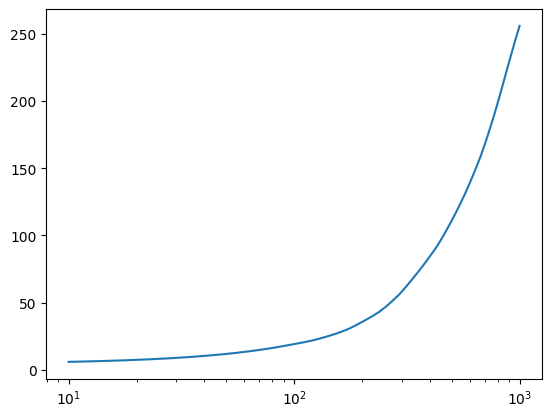

In [88]:
model_pred = [model(y).detach().numpy() for y in torch.tensor([[mlz, yl, f] for f in fs], dtype = torch.float32)]
plt.plot(fs, model_pred)
plt.xscale('log')

In [97]:
import numpy as np
import xgboost as xgb
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

# Define constants
mlz = 1e3
yl = 1
fs = np.logspace(1, 3, num=200, endpoint=True, base=10.0)

# Prepare dataset
X = np.array([[mlz, yl, f] for f in fs], dtype=np.float32)
y = np.array([np.abs(gwmat.cythonized_point_lens.Ff_effective(ml=mlz, y=yl, f=f)) for f in fs], dtype=np.float32)

# Normalize inputs
scaler_X = StandardScaler()
X_scaled = scaler_X.fit_transform(X)

# Normalize outputs
scaler_y = StandardScaler()
y_scaled = scaler_y.fit_transform(y.reshape(-1, 1)).flatten()

# Split dataset (80% train, 20% test)
# X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_scaled, test_size=0.2, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define XGBoost model
xgb_model = xgb.XGBRegressor(
    objective='reg:squarederror',
    n_estimators=500,
    learning_rate=0.05,
    max_depth=6,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42
)

# Train model
xgb_model.fit(X_train, y_train)

# Predict on test set
y_pred = xgb_model.predict(X_test)

# Compute performance
mse = mean_squared_error(y_test, y_pred)
print(f"Test MSE: {mse:.6f}")

# Save model
xgb_model.save_model("xgboost_function_approximator.json")

# To make predictions on new data:
# y_pred_new = scaler_y.inverse_transform(xgb_model.predict(X_new).reshape(-1, 1))


Test MSE: 0.085984


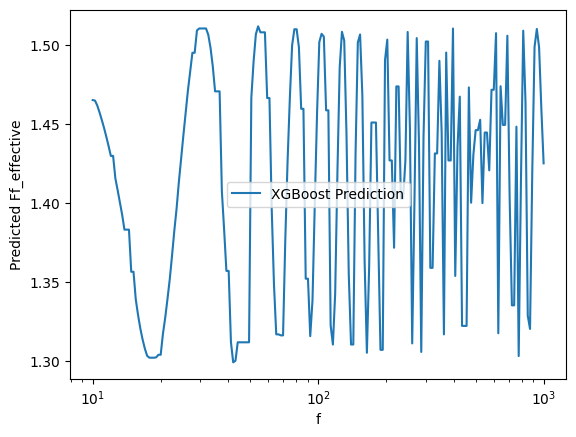

In [98]:
# Prepare input data
X_new = np.array([[mlz, yl, f] for f in fs], dtype=np.float32)
X_new_scaled = scaler_X.transform(X_new)  # Use the fitted scaler

# Predict using XGBoost
# model_pred = xgb_model.predict(X_new_scaled)
model_pred = xgb_model.predict(X_new)

# Inverse transform predictions if needed
model_pred = scaler_y.inverse_transform(model_pred.reshape(-1, 1)).flatten()

# Plot results
plt.plot(fs, model_pred, label="XGBoost Prediction")
plt.xscale('log')
plt.xlabel("f")
plt.ylabel("Predicted Ff_effective")
plt.legend()
plt.show()

# XGBoost Full Run

In [145]:
import numpy as np
import matplotlib.pyplot as plt
import xgboost as xgb
import bilby
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV

In [152]:
# Define frequency range
fs = np.logspace(1, 3, num=200, endpoint=True, base=10.0)

# Define priors for mlz and yl using Bilby
prior = bilby.core.prior.PriorDict()
prior['mlz'] = bilby.prior.LogUniform(minimum=100, maximum=1e5, name='Mlz', latex_label='Mlz')
prior['yl'] = bilby.prior.PowerLaw(alpha=0.1, minimum=0.001, maximum=3, name='Mlz', latex_label='Mlz')

# Sample 100 (mlz, yl) pairs
num_samples = 100
sampled_params = prior.sample(num_samples)

# Prepare dataset
X_list = []
y_list = []


for i in range(num_samples):
    mlz = sampled_params['mlz'][i]
    yl = sampled_params['yl'][i]

    X_temp = np.array([[mlz, yl, f] for f in fs], dtype=np.float32)
    y_temp = np.array([
        np.abs(gwmat.cythonized_point_lens.Ff_effective(ml=mlz, y=yl, f=f)) for f in fs
    ], dtype=np.float32)

    X_list.append(X_temp)
    y_list.append(y_temp)

# Convert lists to arrays
X = np.vstack(X_list)
y = np.concatenate(y_list)

# Normalize inputs
scaler_X = StandardScaler()
X_scaled = scaler_X.fit_transform(X)

# Normalize outputs
scaler_y = StandardScaler()
y_scaled = scaler_y.fit_transform(y.reshape(-1, 1)).flatten()

# Split dataset (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_scaled, test_size=0.2, random_state=42)

# Define XGBoost model
xgb_model = xgb.XGBRegressor(
    objective='reg:squarederror',
    n_estimators=1000,
    learning_rate=0.01,
    max_depth=24,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42
)

# Train model
xgb_model.fit(X_train, y_train)

# Predict on test set
y_pred = xgb_model.predict(X_test)

# Compute performance
mse = mean_squared_error(y_test, y_pred)
print(f"Test MSE: {mse:.6f}")

# Save model
xgb_model.save_model("xgboost_function_approximator.json")

# To make predictions on new data:
# X_new = scaler_X.transform(new_data)
# y_pred_new = scaler_y.inverse_transform(xgb_model.predict(X_new).reshape(-1, 1))

Test MSE: 0.384385


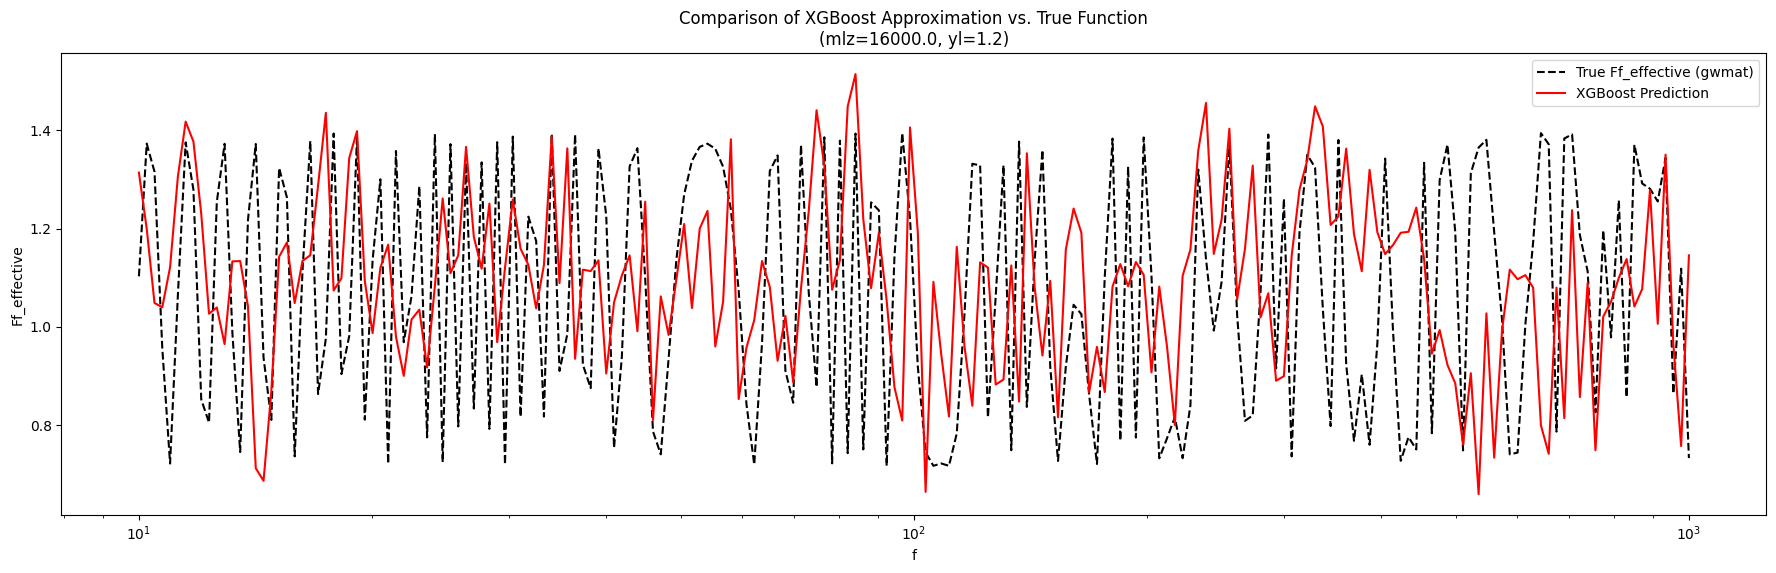

In [153]:
# Define test parameters
mlz_test = 1.6e4
yl_test = 1.2

# Prepare input data
X_new = np.array([[mlz_test, yl_test, f] for f in fs], dtype=np.float32)
X_new_scaled = scaler_X.transform(X_new)  # Scale input

# Predict using XGBoost
# model_pred = xgb_model.predict(X_new_scaled)
model_pred = xgb_model.predict(X_new_scaled)

# Inverse transform predictions
model_pred = scaler_y.inverse_transform(model_pred.reshape(-1, 1)).flatten()
# model_pred = scaler_y.inverse_transform(model_pred.reshape(-1, 1))[:, 0]


# Compute true values from gwmat
true_values = np.array([
    np.abs(gwmat.cythonized_point_lens.Ff_effective(ml=mlz_test, y=yl_test, f=f))
    for f in fs
], dtype=np.float32)

# true_values = scaler_y.inverse_transform(true_values.reshape(-1, 1)).flatten()

# Plot results
plt.figure(figsize=(22, 6))
plt.plot(fs, true_values, label="True Ff_effective (gwmat)", linestyle="dashed", color="black")
plt.plot(fs, model_pred, label="XGBoost Prediction", linestyle="solid", color="red")
plt.xscale('log')
plt.xlabel("f")
plt.ylabel("Ff_effective")
plt.legend()
plt.title(f"Comparison of XGBoost Approximation vs. True Function\n(mlz={mlz_test}, yl={yl_test})")
plt.show()
